# Route distributions

In [1]:
library(RSQLCipher)
suppressMessages(library(lubridate))
suppressWarnings(suppressMessages(library(tidyverse)))
suppressWarnings(suppressMessages(library(lme4)))

# import income functions
suppressMessages(source("../../src/income.R"))

select = dplyr::select

In [2]:
Sys.setenv("SQL_KEY"=Sys.getenv("HOT_KEY"))
options(repr.plot.width=10, repr.plot.height=8)

In [3]:
acs = read_csv("../../data/acs/block_group_census_estimates_wide_wsdot_bins.csv", col_types="cccciiddddddddddddddddddd") %>%
    filter(mean_inc < Inf, !is.na(med_inc)) %>%
    mutate(fips = fips_code) %>% select(-fips_code)

In [4]:
acs_bins = c(0, 20, 35, 50, 75, 100, 125, 150, 200, Inf)

In [5]:
all_counts = acs %>% 
    mutate(group="All") %>%
    inc_distr_by(group, weight=population) %>%
    gather(inc_group, pct, -group, -count) %>%
    mutate(count = count*pct)

fit_all = fit_dagum(all_counts$count, acs_bins)
b = fit_all$par[1]
a = fit_all$par[2]
p = fit_all$par[3]

print(fit_all)
scales::dollar(1000*median(fit_all))

A fitted Dagum distribution with b = 121.38, a = 2.8, and p = 0.43

4833041 total observation(s)
Bins: 0 20 35 50 75 100 125 150 200 Inf


[1] "$74,020.37"

In [6]:
db_path = "../../../data/hot.db"
trips = load_table(db_path, "trips_linked")

In [7]:
trips.2pct = load_table(db_path, "trips_2pct", 
                        c(tag_id="c", acct="c", plate="c", id="c", zip="c")) %>% 
    execute %>%
    mutate(fips=as.character(fips))

Warning message:
“Unnamed `col_types` should have the same length as `col_names`. Using smaller of the two.”Warning message:
“11 parsing failures.
   row col               expected actual         file
 37249 zip a double               V3W7X4 literal data
 37787 zip no trailing characters LY     literal data
 46162 zip a double               V3W7X4 literal data
123282 zip a double               V3W7X4 literal data
132178 zip a double               V3W7X4 literal data
...... ... ...................... ...... ............
See problems(...) for more details.
”

In [8]:
plaza_dist = read_csv("../../data/milepost_lookups/plaza_dist.csv", col_types="cid")

In [9]:
mp_annotations = tribble(
    ~direction, ~mp, ~plaza, ~label,
    "NB", 0, 1, "Bellevue",
    "NB", 2.9, 3.1, "NE 70th",
    "NB", 5, 4, "NE 116th",
    "NB", 6.7, 6, "NE 128th DAR",
    "NB", 9.5, 7.3, "SR 522",
    "NB", 12.5, 8.2, "SR 527",
    "NB", 15.4, 10, "I-5",
    "SB", 0, 1, "I-5",
    "SB", 2, 2.4, "SR 527",
    "SB", 4.5, 3.5, "SR 522",
    "SB", 7.8, 7, "NE 128th DAR",
    "SB", 9.5, 7.8, "NE 85th",
    "SB", 13, 9.5, "SR 520",
    "SB", 14.9, 10, "Bellevue",
)

ann_nb = filter(mp_annotations, direction=="NB")
ann_sb = filter(mp_annotations, direction=="SB")

# Overall volume

In [31]:
route_vols = trips.2pct %>%
    mutate(hour = hour(as_datetime(entry_time)),
           am_peak = hour >= 5 & hour < 9,
           pm_peak = hour >= 15 & hour < 19,
           peak = am_peak | pm_peak,
           peak_group = if_else(am_peak, "AM peak", if_else(pm_peak, "PM peak", "Off-peak"))) %>%
    group_by(entry_plaza, exit_plaza, peak_group) %>%
    summarize(volume=n()*16976134/nrow(trips.2pct)) %>%
    arrange(entry_plaza, exit_plaza, peak_group)

In [33]:
vol_overall = route_vols %>%
    ungroup() %>%
    mutate(direction = if_else(entry_plaza <= 12, "NB", "SB"),
           entry_plaza = if_else(direction=="NB", entry_plaza-2, entry_plaza-12),
           exit_plaza = if_else(direction=="NB", exit_plaza-2, exit_plaza-12),
           id = str_glue("{entry_plaza}_{exit_plaza}")) %>%
    left_join(plaza_dist, by=c("direction", "entry_plaza"="plaza")) %>%
    rename(entry_mp=dist_origin) %>%
    left_join(plaza_dist, by=c("direction", "exit_plaza"="plaza")) %>%
    rename(exit_mp=dist_origin) %>%
    mutate(trip_dist = exit_mp - entry_mp)# %>%
    #group_by(entry_plaza, exit_plaza, direction)

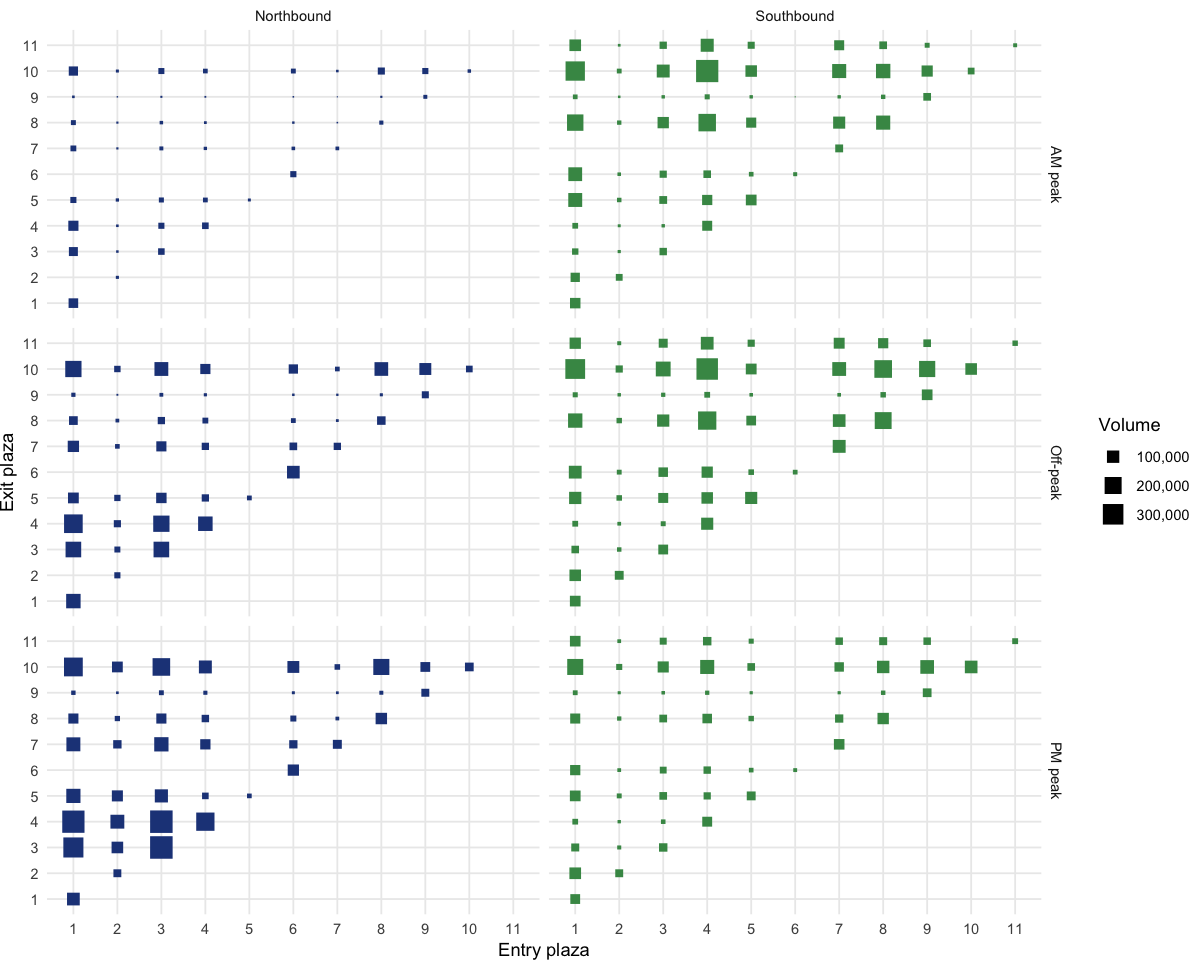

In [41]:
vol_overall %>%
    ungroup %>%
    mutate(direction = if_else(direction == "NB", "Northbound", "Southbound")) %>%
ggplot(aes(as_factor(entry_plaza), as_factor(exit_plaza), color=direction, size=volume)) +
    #facet_wrap("direction") +
    facet_grid(peak_group ~ direction) +
    geom_point(shape=15) + 
    scale_color_manual(values=c("#224488", "#449555")) +
    scale_size_continuous(labels=scales::comma, range=c(0,6)) +
    guides(color=F) +
    labs(size="Volume", x="Entry plaza", y="Exit plaza") +
    theme_minimal() +
    theme(plot.margin=grid::unit(c(0,0,0,0), "mm"))

In [42]:
ggsave("../../../img/trips_vol.png", width=6.5, height=6, dpi=320)

TableGrob (2 x 1) "arrange": 2 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]

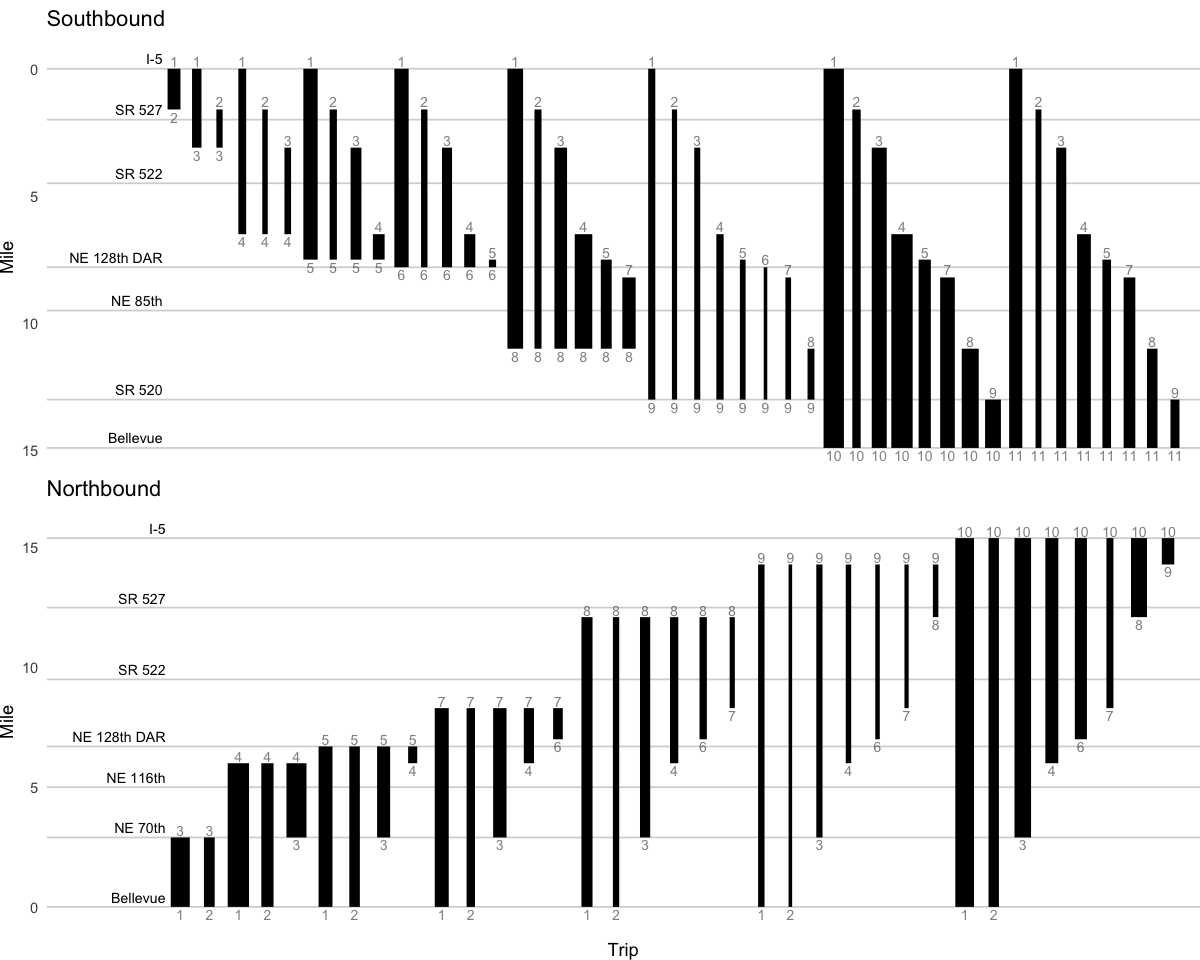

In [14]:
p_NB = filter(vol_overall, direction=="NB", entry_plaza != exit_plaza) %>%
    ggplot(aes(reorder(id, exit_plaza), ymin=entry_mp, ymax=exit_mp, size=volume)) + 
        geom_hline(aes(yintercept=mp), lty="solid", alpha=0.2, data=ann_nb) +
        geom_linerange() + 
        geom_text(aes(x=0.5, y=mp, label=label), size=3, hjust="right", nudge_y=0.4, data=ann_nb, inherit.aes=F) +
        geom_text(aes(label=exit_plaza, y=exit_mp), size=3, color="black", alpha=0.5, nudge_y=0.3) + 
        geom_text(aes(label=entry_plaza, y=entry_mp), size=3, color="black", alpha=0.5, nudge_y=-0.3) + 
        coord_cartesian(xlim=c(-3, 35.5)) + 
        guides(size=F) + 
        theme_minimal() +
        theme(panel.grid=element_blank(), plot.margin=grid::unit(c(0,0,0,0), "mm"),
              axis.text.x=element_blank(), axis.ticks.x=element_blank()) +
        labs(title="Northbound", x="Trip", y="Mile", color="Med. Inc.")
p_SB = filter(vol_overall, direction=="SB", entry_plaza != exit_plaza) %>%
    ggplot(aes(reorder(id, exit_plaza), ymin=entry_mp, ymax=exit_mp, size=volume)) + 
        geom_hline(aes(yintercept=mp), lty="solid", alpha=0.2, data=ann_sb) +
        geom_linerange() + 
        geom_text(aes(x=0.5, y=mp, label=label), size=3, hjust="right", nudge_y=0.4, data=ann_sb, inherit.aes=F) +
        geom_text(aes(label=exit_plaza, y=exit_mp), size=3, color="black", alpha=0.5, nudge_y=-0.3) + 
        geom_text(aes(label=entry_plaza, y=entry_mp), size=3, color="black", alpha=0.5, nudge_y=+0.3) + 
        coord_cartesian(xlim=c(-4, 45.5)) + 
        theme() + 
        guides(size=F) + 
        scale_y_reverse() +
        theme_minimal() +
        theme(panel.grid=element_blank(), plot.margin=grid::unit(c(2,0,0,0), "mm"),
              axis.text.x=element_blank(), axis.ticks.x=element_blank()) +
        labs(title="Southbound", x=NULL, y="Mile", color="Med. Inc.")
p = gridExtra::grid.arrange(p_SB, p_NB, ncol=1, padding=0)
p

# Income distribution

In [30]:
route_vols = trips.2pct %>%
    filter(commercial == 0, is_hov == 0) %>%
    rename(entry=entry_plaza, exit=exit_plaza) %>%
    mutate(direction = if_else(entry <= 12, "NB", "SB"),
           entry = if_else(direction=="NB", entry-2, entry-12),
           exit = if_else(direction=="NB", exit-2, exit-12),
           id = str_glue("{direction}_{entry}_{exit}")) %>%
    block_counts_by(id, acs) %>%
    fit_ecolg(vary_slopes=F) %>%
    ecolg_quantiles(0.5, fit_all) %>%
    separate(id, c("direction", "entry", "exit"), remove=F, convert=T) %>%
    left_join(plaza_dist, by=c("direction", "entry"="plaza")) %>%
    rename(entry_mp=dist_origin) %>%
    left_join(plaza_dist, by=c("direction", "exit"="plaza")) %>%
    rename(exit_mp=dist_origin) %>%
    mutate(trip_dist = exit_mp - entry_mp)

In [30]:
p_NB = filter(route_vols, direction=="NB", entry != exit) %>%
ggplot(aes(reorder(id, exit), ymin=entry_mp, ymax=exit_mp+0.2, size=count, color=est_50)) + 
    geom_hline(aes(yintercept=mp), lty="solid", alpha=0.2, data=ann_nb) +
    geom_linerange() + 
    geom_text(aes(x=0.5, y=mp, label=label), size=3, hjust="right", nudge_y=0.2, data=ann_nb, inherit.aes=F) +
    geom_text(aes(label=exit, y=exit_mp), size=3, color="black", alpha=0.5, nudge_y=0.4) + 
    geom_text(aes(label=entry, y=entry_mp), size=3, color="black", alpha=0.5, nudge_y=-0.2) + 
    coord_cartesian(xlim=c(-3, 35.5)) + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + 
    guides(size=F, alpha=F) + 
    scale_color_viridis_c(label=scales::dollar, limits=c(50e3, 120e3), oob=scales::squish) + 
    theme_minimal() +
    theme(panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          plot.margin=grid::unit(c(1,0,0,0), "mm"))
    labs(title="Northbound trips, ordered by exit point", x="Trip", y="Mile", color="Med. Inc.")

p_SB = filter(route_vols, direction=="SB", entry != exit) %>%
ggplot(aes(reorder(id, entry), ymin=entry_mp, ymax=exit_mp+0.2, size=count, color=est_50)) + 
    geom_hline(aes(yintercept=mp), lty="solid", alpha=0.2, data=ann_sb) +
    geom_linerange() + 
    geom_text(aes(x=0.4, y=mp, label=label), size=3, hjust="right", nudge_y=0.2, data=ann_sb, inherit.aes=F) +
    geom_text(aes(label=exit, y=exit_mp), size=3, color="black", alpha=0.5, nudge_y=-0.4) + 
    geom_text(aes(label=entry, y=entry_mp), size=3, color="black", alpha=0.5, nudge_y=+0.2) + 
    coord_cartesian(xlim=c(-4, 44.5)) + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + 
    guides(size=F, alpha=F) + 
    scale_color_viridis_c(label=scales::dollar, limits=c(50e3, 120e3), oob=scales::squish) + 
    scale_y_reverse() +
    theme_minimal() +
    theme(panel.grid.major.x = element_blank(),
          panel.grid.minor.x = element_blank(),
          plot.margin=grid::unit(c(1,0,0,0), "mm"))
    labs(title="Southbound trips, ordered by entry point", x=NULL, y="Mile", color="Med. Inc.")
gridExtra::grid.arrange(p_SB, p_NB, ncol=1, padding=0)

ERROR: Error in ~direction == "NB": object 'direction' not found


# Modal distribution

In [18]:
route_vols = trips.2pct %>%
    rename(entry=entry_plaza, exit=exit_plaza) %>%
    mutate(direction = if_else(entry <= 12, "NB", "SB"),
           entry = if_else(direction=="NB", entry-2, entry-12),
           exit = if_else(direction=="NB", exit-2, exit-12),
           id = str_glue("{direction}_{entry}_{exit}")) %>%
    group_by(id, direction, entry, exit, is_hov) %>%
    summarize(volume=n()) %>%
    group_by(id, direction, entry, exit) %>%
    mutate(pct_hov = volume/sum(volume),
           volume = sum(volume)) %>% 
    ungroup %>%
    filter(is_hov==1, entry != exit) %>%
    left_join(plaza_dist, by=c("direction", "entry"="plaza")) %>%
    rename(entry_mp=dist_origin) %>%
    left_join(plaza_dist, by=c("direction", "exit"="plaza")) %>%
    rename(exit_mp=dist_origin) %>%
    mutate(trip_dist = exit_mp - entry_mp)

Warning message:
“Removed 3 rows containing missing values (geom_point).”Warning message:
“Removed 3 rows containing missing values (geom_point).”

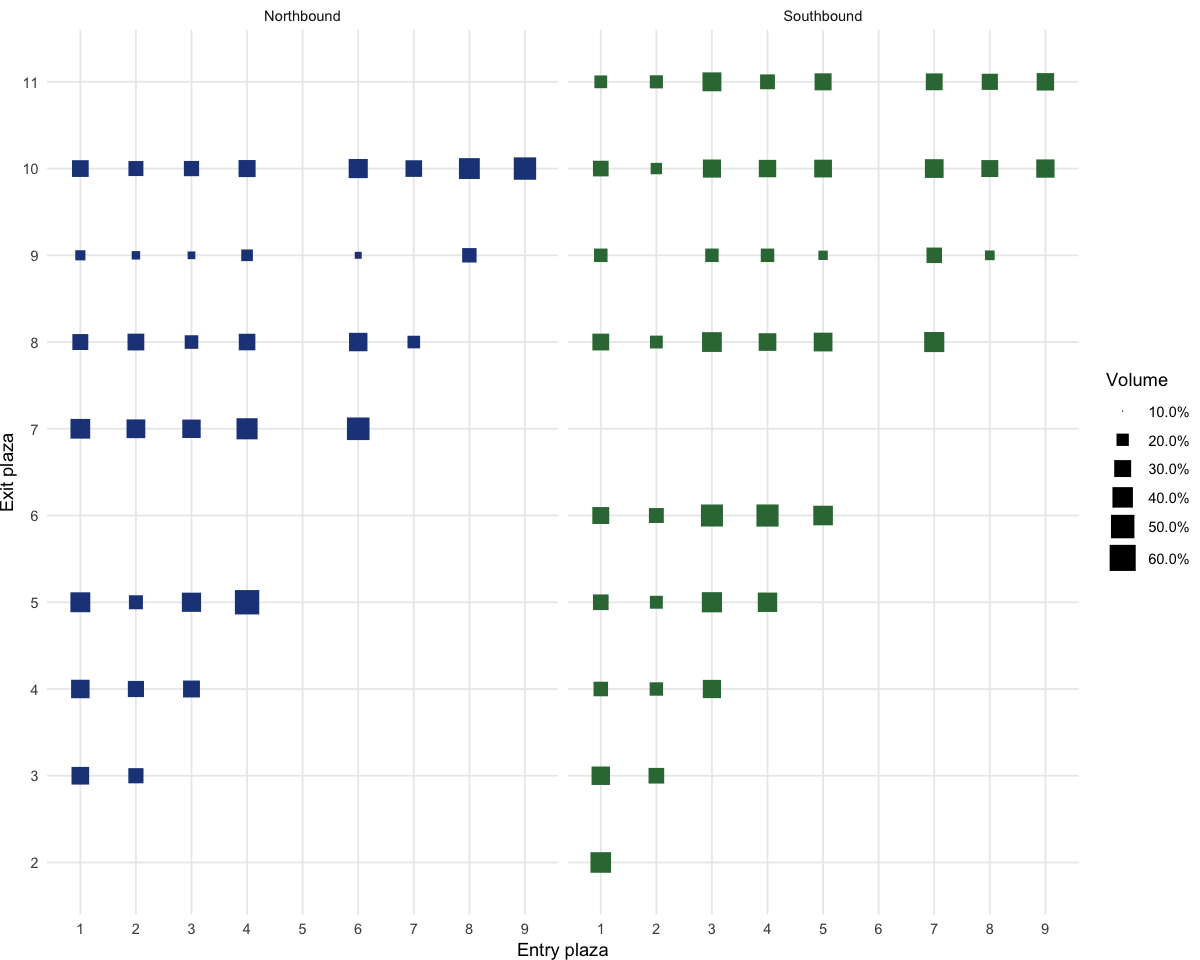

In [19]:
route_vols %>%
    mutate(direction = if_else(direction == "NB", "Northbound", "Southbound")) %>%
ggplot(aes(as_factor(entry), as_factor(exit), color=direction, size=pct_hov)) +
    facet_wrap("direction") +
    geom_point(shape=15) + 
    scale_color_manual(values=c("#224488", "#337744")) +
    scale_size_continuous(labels=scales::percent, range=c(0, 7), limits=c(0.1, 0.6)) +#, oob=scales::squish) +
    guides(color=F) +
    labs(size="Volume", x="Entry plaza", y="Exit plaza") +
    theme_minimal() +
    theme(plot.margin=grid::unit(c(0,0,0,0), "mm"))

ggsave("../../../img/trips_hov.png", width=6.5, height=3, dpi=320)

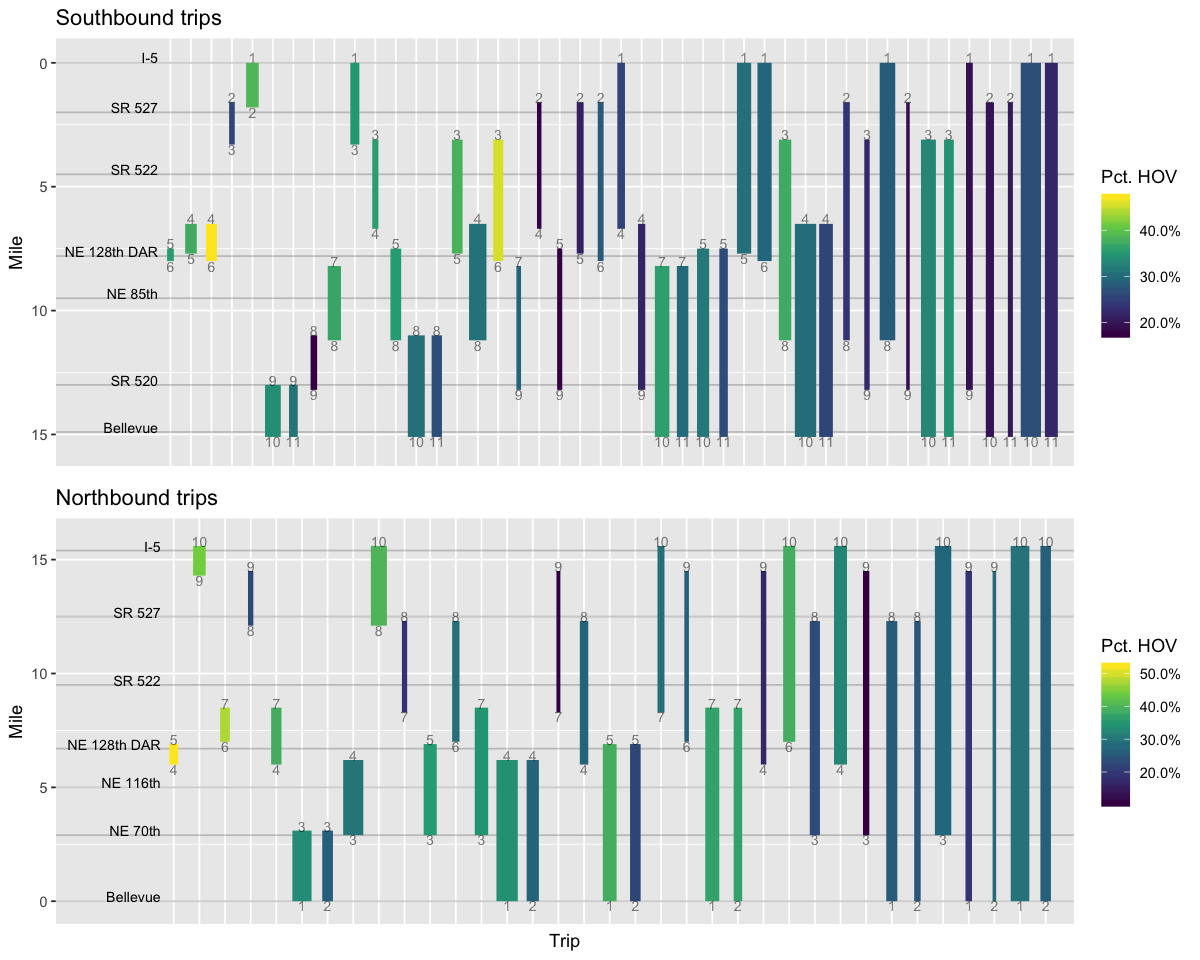

In [86]:
p_NB = filter(route_vols, direction=="NB", entry != exit) %>%
ggplot(aes(reorder(id, trip_dist), ymin=entry_mp, ymax=exit_mp+0.2, size=volume, color=pct_hov)) + 
    geom_hline(aes(yintercept=mp), lty="solid", alpha=0.2, data=ann_nb) +
    geom_linerange() + 
    geom_text(aes(x=0.5, y=mp, label=label), size=3, hjust="right", nudge_y=0.2, data=ann_nb, inherit.aes=F) +
    geom_text(aes(label=exit, y=exit_mp), size=3, color="black", alpha=0.5, nudge_y=0.4) + 
    geom_text(aes(label=entry, y=entry_mp), size=3, color="black", alpha=0.5, nudge_y=-0.2) + 
    coord_cartesian(xlim=c(-3, 35.5)) + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + 
    guides(size=F, alpha=F) + 
    scale_color_viridis_c(label=scales::percent) +
    labs(title="Northbound trips", x="Trip", y="Mile", color="Pct. HOV")

p_SB = filter(route_vols, direction=="SB", entry != exit) %>%
ggplot(aes(reorder(id, trip_dist), ymin=entry_mp, ymax=exit_mp+0.2, size=volume, color=pct_hov)) + 
    geom_hline(aes(yintercept=mp), lty="solid", alpha=0.2, data=ann_sb) +
    geom_linerange() + 
    geom_text(aes(x=0.4, y=mp, label=label), size=3, hjust="right", nudge_y=0.2, data=ann_sb, inherit.aes=F) +
    geom_text(aes(label=exit, y=exit_mp), size=3, color="black", alpha=0.5, nudge_y=-0.4) + 
    geom_text(aes(label=entry, y=entry_mp), size=3, color="black", alpha=0.5, nudge_y=+0.2) + 
    coord_cartesian(xlim=c(-4, 44.5)) + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + 
    guides(size=F, alpha=F) + 
    scale_y_reverse() +
    scale_color_viridis_c(label=scales::percent) +
    labs(title="Southbound trips", x=NULL, y="Mile", color="Pct. HOV")
gridExtra::grid.arrange(p_SB, p_NB, ncol=1, padding=0)

# Distribution by toll

In [20]:
route_vols = trips.2pct %>%
    rename(entry=entry_plaza, exit=exit_plaza) %>%
    mutate(direction = if_else(entry <= 12, "NB", "SB"),
           entry = if_else(direction=="NB", entry-2, entry-12),
           exit = if_else(direction=="NB", exit-2, exit-12),
           id = str_glue("{direction}_{entry}_{exit}")) %>%
    filter(toll > 0) %>%
    group_by(id, direction, entry, exit) %>%
    summarize(avg_toll = mean(toll),
              volume=n()) %>%
    filter(entry != exit) %>%
    left_join(plaza_dist, by=c("direction", "entry"="plaza")) %>%
    rename(entry_mp=dist_origin) %>%
    left_join(plaza_dist, by=c("direction", "exit"="plaza")) %>%
    rename(exit_mp=dist_origin) %>%
    mutate(trip_dist = exit_mp - entry_mp)

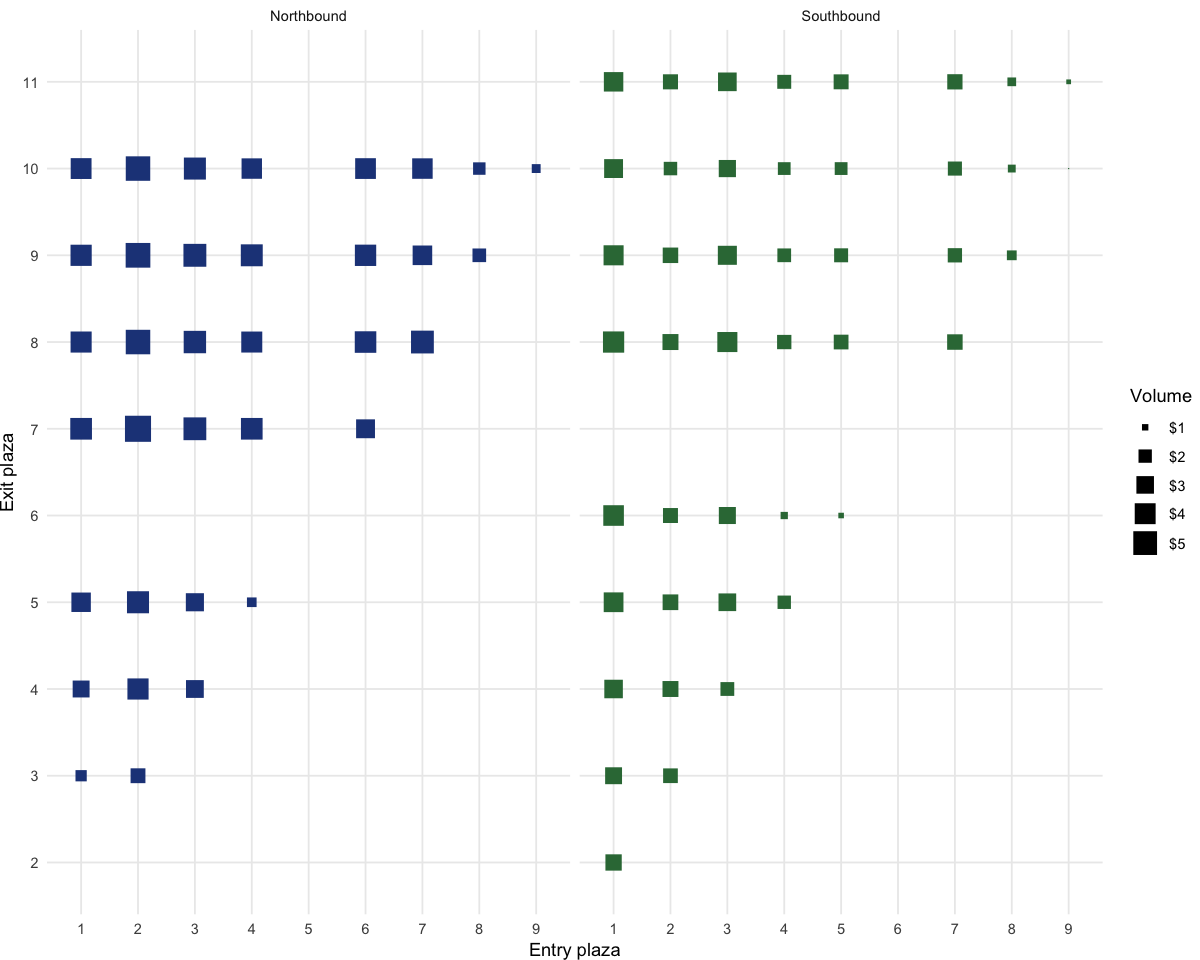

In [21]:
route_vols %>%
    ungroup() %>%
    mutate(direction = if_else(direction == "NB", "Northbound", "Southbound")) %>%
ggplot(aes(as_factor(entry), as_factor(exit), color=direction, size=avg_toll)) +
    facet_wrap("direction") +
    geom_point(shape=15) + 
    scale_color_manual(values=c("#224488", "#337744")) +
    scale_size_continuous(labels=scales::dollar, range=c(0, 7)) +
    guides(color=F) +
    labs(size="Volume", x="Entry plaza", y="Exit plaza") +
    theme_minimal() +
    theme(plot.margin=grid::unit(c(0,0,0,0), "mm"))

ggsave("../../../img/trips_toll.png", width=6.5, height=3, dpi=320)

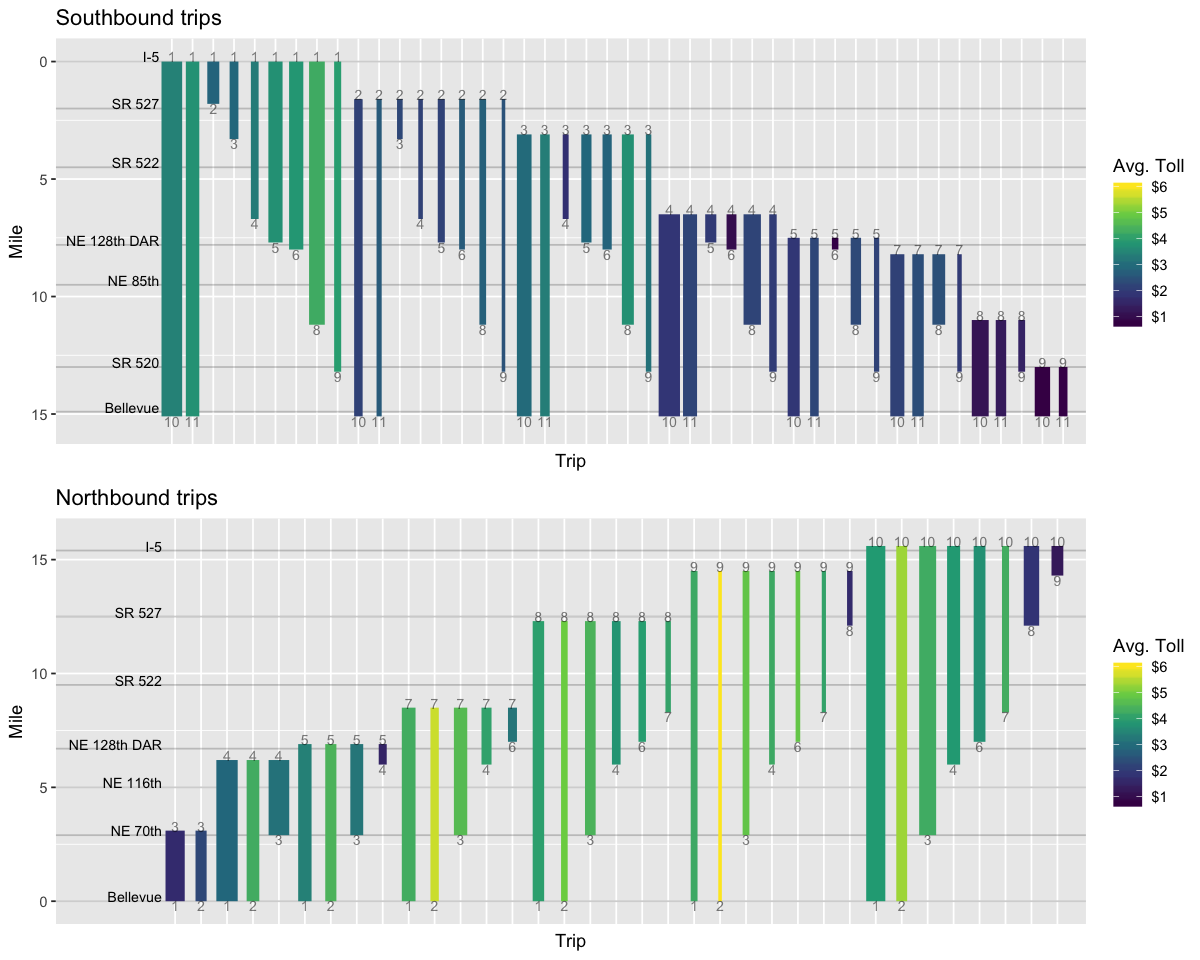

In [100]:
p_SB = filter(route_vols, direction=="SB", entry != exit) %>%
ggplot(aes(reorder(id, entry), ymin=entry_mp, ymax=exit_mp+0.2, size=volume, color=avg_toll)) + 
    geom_hline(aes(yintercept=mp), lty="solid", alpha=0.2, data=ann_sb) +
    geom_linerange() + 
    geom_text(aes(x=0.4, y=mp, label=label), size=3, hjust="right", nudge_y=0.2, data=ann_sb, inherit.aes=F) +
    geom_text(aes(label=exit, y=exit_mp), size=3, color="black", alpha=0.5, nudge_y=-0.4) + 
    geom_text(aes(label=entry, y=entry_mp), size=3, color="black", alpha=0.5, nudge_y=+0.2) + 
    coord_cartesian(xlim=c(-4, 44.5)) + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + 
    guides(size=F, alpha=F) + 
    scale_y_reverse() +
    scale_color_viridis_c(label=scales::dollar, limits=c(0.75, 6), oob=scales::squish) +
    labs(title="Southbound trips", x="Trip", y="Mile", color="Avg. Toll")

p_NB = filter(route_vols, direction=="NB", entry != exit) %>%
ggplot(aes(reorder(id, exit), ymin=entry_mp, ymax=exit_mp+0.2, size=volume, color=avg_toll)) + 
    geom_hline(aes(yintercept=mp), lty="solid", alpha=0.2, data=ann_nb) +
    geom_linerange() + 
    geom_text(aes(x=0.5, y=mp, label=label), size=3, hjust="right", nudge_y=0.2, data=ann_nb, inherit.aes=F) +
    geom_text(aes(label=exit, y=exit_mp), size=3, color="black", alpha=0.5, nudge_y=0.4) + 
    geom_text(aes(label=entry, y=entry_mp), size=3, color="black", alpha=0.5, nudge_y=-0.2) + 
    coord_cartesian(xlim=c(-3, 35.5)) + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + 
    guides(size=F, alpha=F) + 
    scale_color_viridis_c(label=scales::dollar, limits=c(0.75, 6), oob=scales::squish) +
    labs(title="Northbound trips", x="Trip", y="Mile", color="Avg. Toll")

gridExtra::grid.arrange(p_SB, p_NB, ncol=1, padding=0)

In [12]:
route_vols = trips.2pct %>%
    rename(entry=entry_plaza, exit=exit_plaza) %>%
    mutate(direction = if_else(entry <= 12, "NB", "SB"),
           entry = if_else(direction=="NB", entry-2, entry-12),
           exit = if_else(direction=="NB", exit-2, exit-12),
           id = str_glue("{direction}_{entry}_{exit}"),
           num_lanes = case_when(
               direction == "NB" & entry >= 7 ~ "1",
               direction == "NB" & exit >= 7 ~ "1",
               direction == "SB" & entry <= 3 ~ "1",
               direction == "SB" & exit <= 3 ~ "1",
               T ~ "2"
           ),
           max_toll = toll == 10) %>%
    filter(toll > 0) %>%
    group_by(id, direction, entry, exit, num_lanes, max_toll) %>%
    summarize(volume=n()) %>%
    group_by(id, direction, entry, exit, num_lanes) %>%
    mutate(pct = volume/sum(volume),
           volume = sum(volume)) %>%
    ungroup %>%
    filter(max_toll == T, entry != exit) %>%
    left_join(plaza_dist, by=c("direction", "entry"="plaza")) %>%
    rename(entry_mp=dist_origin) %>%
    left_join(plaza_dist, by=c("direction", "exit"="plaza")) %>%
    rename(exit_mp=dist_origin) %>%
    mutate(trip_dist = exit_mp - entry_mp)
head(route_vols)

id,direction,entry,exit,num_lanes,max_toll,volume,pct,entry_mp,exit_mp,trip_dist
<glue>,<chr>,<dbl>,<dbl>,<chr>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
NB_1_10,NB,1,10,1,TRUE,4993,0.114960945,0,15.4,15.4
NB_1_3,NB,1,3,2,TRUE,5034,0.004568931,0,2.9,2.9
NB_1_4,NB,1,4,2,TRUE,6447,0.045757717,0,6.0,6.0
NB_1_5,NB,1,5,2,TRUE,2084,0.063819578,0,6.7,6.7
NB_1_7,NB,1,7,1,TRUE,2114,0.130558184,0,8.3,8.3
NB_1_8,NB,1,8,1,TRUE,1286,0.122861586,0,12.1,12.1


In [23]:
onelane.sec = tribble(
    ~direction, ~start, ~end,
    "Northbound", 7, 10,
    "Southbound", 3, 11
)

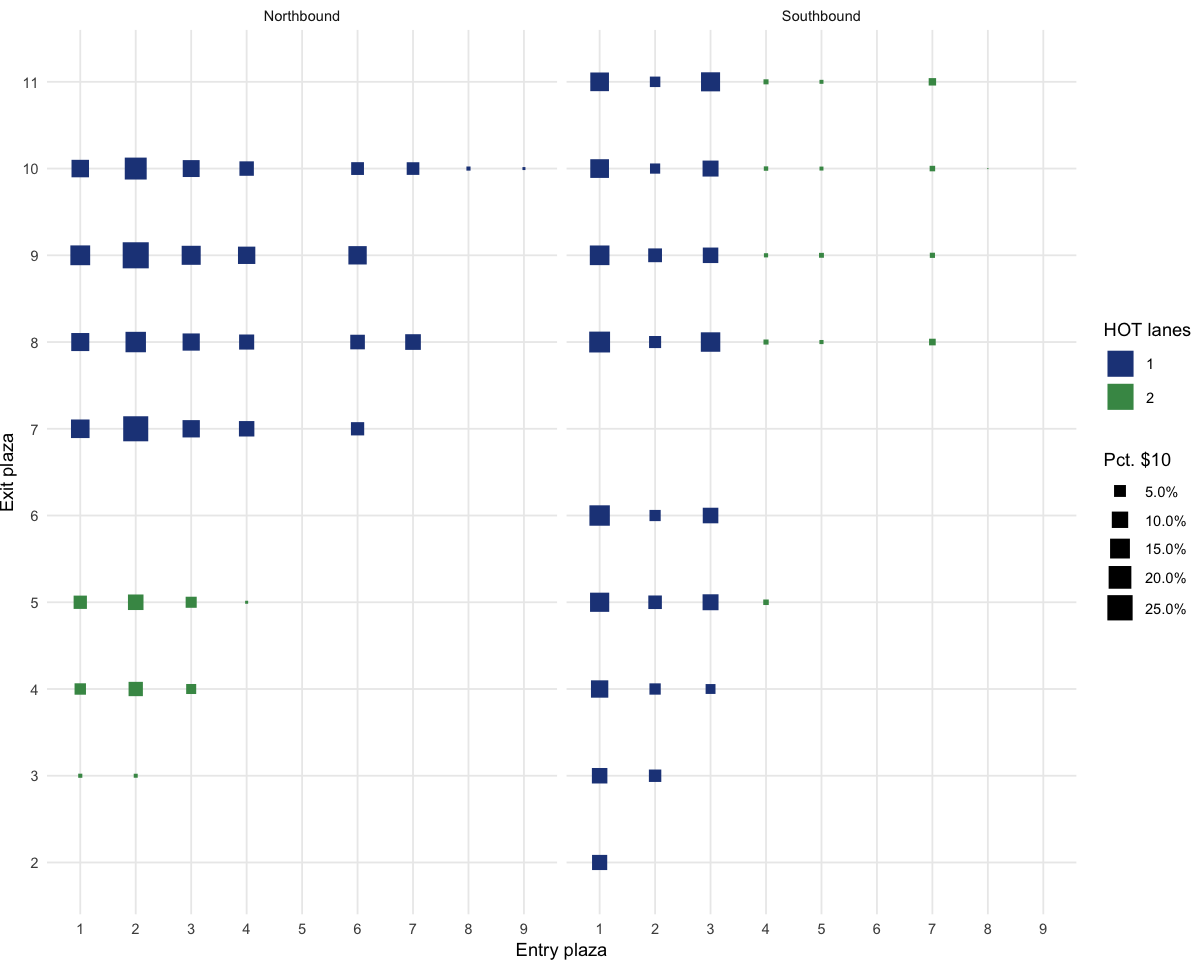

In [27]:
route_vols %>%
    ungroup() %>%
    mutate(direction = if_else(direction == "NB", "Northbound", "Southbound")) %>%
ggplot(aes(as_factor(entry), as_factor(exit), color=num_lanes, size=pct)) +
    facet_wrap("direction") +
    #geom_rect(aes(ymin=as.factor(start), ymax=as.factor(end), xmin=1, xmax=10), data=onelane.sec, inherit.aes=F, alpha=0.4) +
    geom_point(shape=15) + 
    scale_color_manual(values=c("#224488", "#449555")) +
    scale_size_continuous(labels=scales::percent, range=c(0, 7)) +
    labs(size="Pct. $10", x="Entry plaza", y="Exit plaza", color="HOT lanes") +
    guides(color=guide_legend(override.aes=list(size=7))) +
    theme_minimal() +
    theme(plot.margin=grid::unit(c(0,0,0,0), "mm"))

ggsave("../../../img/trips_toll.png", width=6.5, height=3, dpi=320)

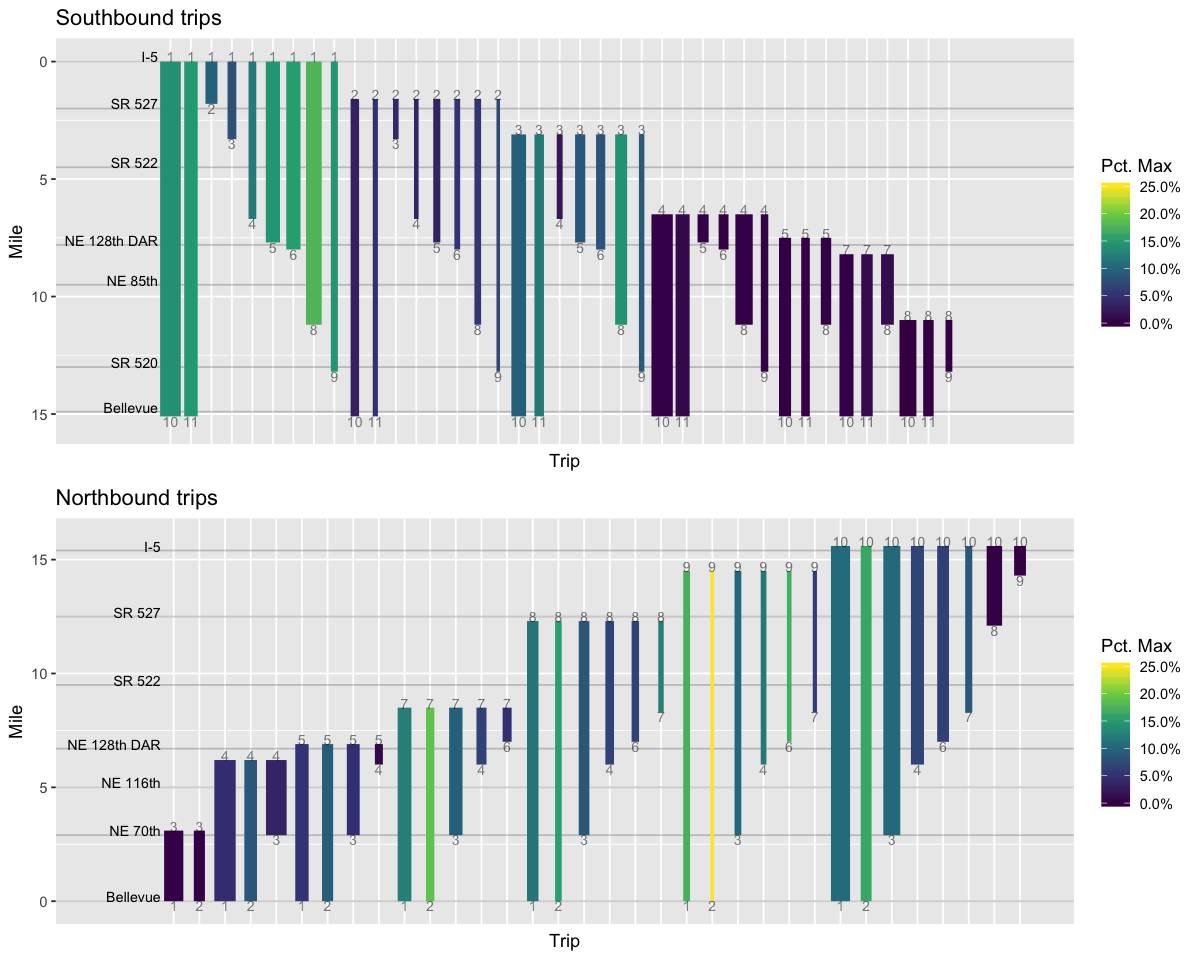

In [103]:
p_SB = filter(route_vols, direction=="SB", entry != exit) %>%
ggplot(aes(reorder(id, entry), ymin=entry_mp, ymax=exit_mp+0.2, size=volume, color=pct)) + 
    geom_hline(aes(yintercept=mp), lty="solid", alpha=0.2, data=ann_sb) +
    geom_linerange() + 
    geom_text(aes(x=0.4, y=mp, label=label), size=3, hjust="right", nudge_y=0.2, data=ann_sb, inherit.aes=F) +
    geom_text(aes(label=exit, y=exit_mp), size=3, color="black", alpha=0.5, nudge_y=-0.4) + 
    geom_text(aes(label=entry, y=entry_mp), size=3, color="black", alpha=0.5, nudge_y=+0.2) + 
    coord_cartesian(xlim=c(-4, 44.5)) + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + 
    guides(size=F, alpha=F) + 
    scale_y_reverse() +
    scale_color_viridis_c(label=scales::percent, limits=c(0, 0.25), oob=scales::squish) +
    labs(title="Southbound trips", x="Trip", y="Mile", color="Pct. Max")

p_NB = filter(route_vols, direction=="NB", entry != exit) %>%
ggplot(aes(reorder(id, exit), ymin=entry_mp, ymax=exit_mp+0.2, size=volume, color=pct)) + 
    geom_hline(aes(yintercept=mp), lty="solid", alpha=0.2, data=ann_nb) +
    geom_linerange() + 
    geom_text(aes(x=0.5, y=mp, label=label), size=3, hjust="right", nudge_y=0.2, data=ann_nb, inherit.aes=F) +
    geom_text(aes(label=exit, y=exit_mp), size=3, color="black", alpha=0.5, nudge_y=0.4) + 
    geom_text(aes(label=entry, y=entry_mp), size=3, color="black", alpha=0.5, nudge_y=-0.2) + 
    coord_cartesian(xlim=c(-3, 35.5)) + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + 
    guides(size=F, alpha=F) + 
    scale_color_viridis_c(label=scales::percent, limits=c(0, 0.25), oob=scales::squish) +
    labs(title="Northbound trips", x="Trip", y="Mile", color="Pct. Max")

gridExtra::grid.arrange(p_SB, p_NB, ncol=1, padding=0)

# Distribution by user frequency

In [116]:
route_vols = trips.2pct %>%
    rename(entry=entry_plaza, exit=exit_plaza) %>%
    mutate(direction = if_else(entry <= 12, "NB", "SB"),
           entry = if_else(direction=="NB", entry-2, entry-12),
           exit = if_else(direction=="NB", exit-2, exit-12),
           id = str_glue("{direction}_{entry}_{exit}")) %>%
    mutate(freq = fct_collapse(freq, NULL="6_high",
                               low=c("1_single", "2_monthly", "3_weekly"), 
                               high=c("4_regular", "5_daily"),)) %>%
    drop_na(freq) %>%
    group_by(id, direction, entry, exit, freq) %>%
    summarize(volume=n()) %>%
    group_by(id, direction, entry, exit) %>%
    mutate(pct = volume/sum(volume),
           volume = sum(volume)) %>%
    ungroup %>%
    filter(freq=="high", entry != exit) %>%
    left_join(plaza_dist, by=c("direction", "entry"="plaza")) %>%
    rename(entry_mp=dist_origin) %>%
    left_join(plaza_dist, by=c("direction", "exit"="plaza")) %>%
    rename(exit_mp=dist_origin) %>%
    mutate(trip_dist = exit_mp - entry_mp)
head(route_vols)

id,direction,entry,exit,freq,volume,pct,entry_mp,exit_mp,trip_dist
<glue>,<chr>,<dbl>,<dbl>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
NB_1_10,NB,1,10,high,5492,0.4759650,0,15.4,15.4
NB_1_3,NB,1,3,high,6234,0.5521335,0,2.9,2.9
NB_1_4,NB,1,4,high,7830,0.5628352,0,6.0,6.0
NB_1_5,NB,1,5,high,2807,0.6145351,0,6.7,6.7
NB_1_7,NB,1,7,high,2684,0.5122951,0,8.3,8.3
NB_1_8,NB,1,8,high,1422,0.3396624,0,12.1,12.1


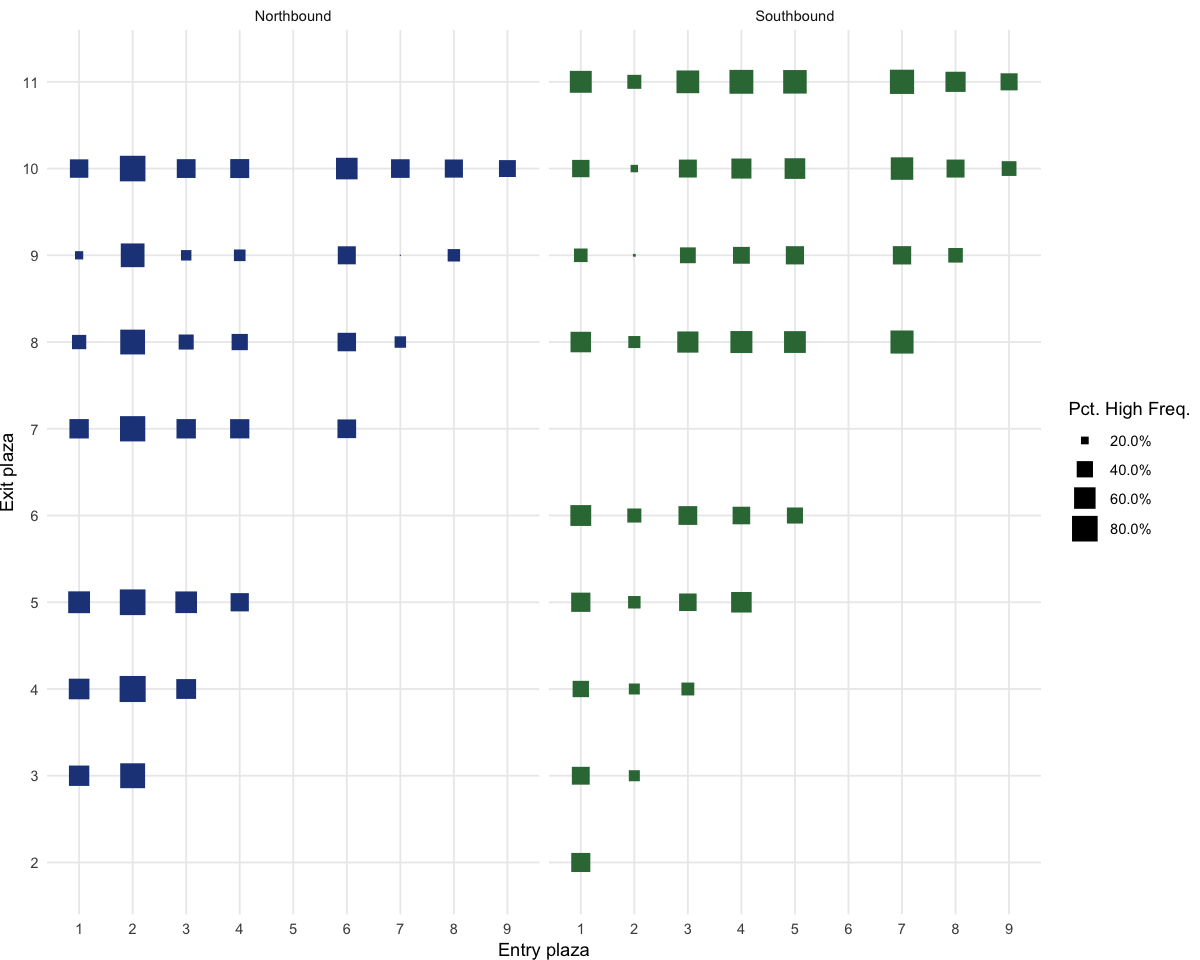

In [118]:
route_vols %>%
    ungroup() %>%
    mutate(direction = if_else(direction == "NB", "Northbound", "Southbound")) %>%
ggplot(aes(as_factor(entry), as_factor(exit), color=direction, size=pct)) +
    facet_wrap("direction") +
    geom_point(shape=15) + 
    scale_color_manual(values=c("#224488", "#337744")) +
    scale_size_continuous(labels=scales::percent, range=c(0, 7)) +
    guides(color=F) +
    labs(size="Pct. High Freq.", x="Entry plaza", y="Exit plaza", color="HOT lanes") +
    theme_minimal() +
    theme(plot.margin=grid::unit(c(0,0,0,0), "mm"))

ggsave("../../../img/trips_freq.png", width=6.5, height=3, dpi=320)

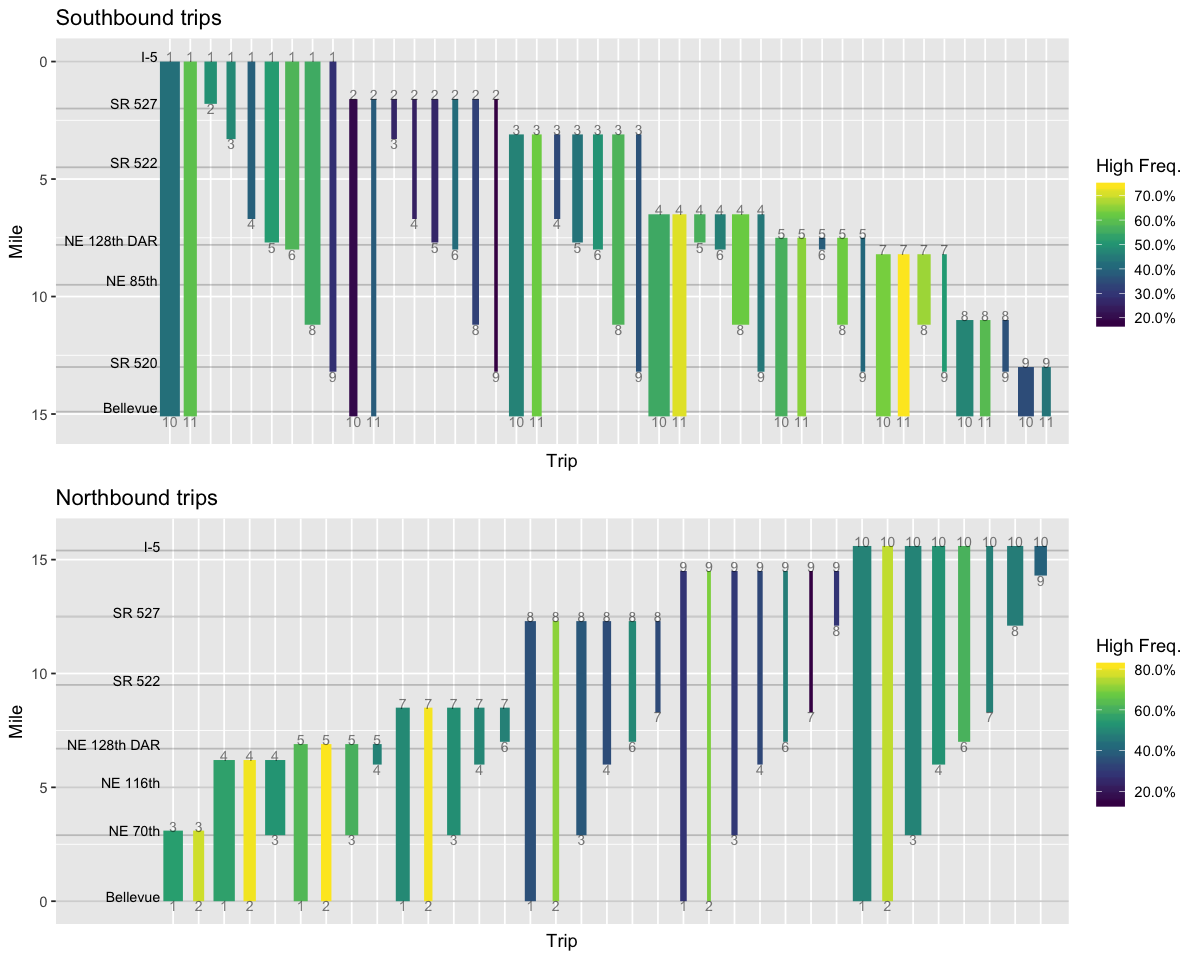

In [88]:
p_SB = filter(route_vols, direction=="SB", entry != exit) %>%
ggplot(aes(reorder(id, entry), ymin=entry_mp, ymax=exit_mp+0.2, size=volume, color=pct)) + 
    geom_hline(aes(yintercept=mp), lty="solid", alpha=0.2, data=ann_sb) +
    geom_linerange() + 
    geom_text(aes(x=0.4, y=mp, label=label), size=3, hjust="right", nudge_y=0.2, data=ann_sb, inherit.aes=F) +
    geom_text(aes(label=exit, y=exit_mp), size=3, color="black", alpha=0.5, nudge_y=-0.4) + 
    geom_text(aes(label=entry, y=entry_mp), size=3, color="black", alpha=0.5, nudge_y=+0.2) + 
    coord_cartesian(xlim=c(-4, 44.5)) + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + 
    guides(size=F, alpha=F) + 
    scale_y_reverse() +
    scale_color_viridis_c(label=scales::percent) +
    labs(title="Southbound trips", x="Trip", y="Mile", color="High Freq.")

p_NB = filter(route_vols, direction=="NB", entry != exit) %>%
ggplot(aes(reorder(id, exit), ymin=entry_mp, ymax=exit_mp+0.2, size=volume, color=pct)) + 
    geom_hline(aes(yintercept=mp), lty="solid", alpha=0.2, data=ann_nb) +
    geom_linerange() + 
    geom_text(aes(x=0.5, y=mp, label=label), size=3, hjust="right", nudge_y=0.2, data=ann_nb, inherit.aes=F) +
    geom_text(aes(label=exit, y=exit_mp), size=3, color="black", alpha=0.5, nudge_y=0.4) + 
    geom_text(aes(label=entry, y=entry_mp), size=3, color="black", alpha=0.5, nudge_y=-0.2) + 
    coord_cartesian(xlim=c(-3, 35.5)) + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + 
    guides(size=F, alpha=F) + 
    scale_color_viridis_c(label=scales::percent) +
    labs(title="Northbound trips", x="Trip", y="Mile", color="High Freq.")

gridExtra::grid.arrange(p_SB, p_NB, ncol=1, padding=0)

# Distribution by peak users

In [26]:
route_vols = trips.2pct %>%
    rename(entry=entry_plaza, exit=exit_plaza) %>%
    mutate(direction = if_else(entry <= 12, "NB", "SB"),
           entry = if_else(direction=="NB", entry-2, entry-12),
           exit = if_else(direction=="NB", exit-2, exit-12),
           id = str_glue("{direction}_{entry}_{exit}"),
           hour = hour(as_datetime(entry_time)),
           am_peak = hour >= 5 & hour < 9 & direction == "SB",
           pm_peak = hour >= 15 & hour < 19 & direction == "NB",
           peak = am_peak | pm_peak) %>%
    group_by(id, direction, entry, exit, peak) %>%
    summarize(volume=n()) %>%
    group_by(id, direction, entry, exit) %>%
    mutate(pct = volume/sum(volume),
           volume = sum(volume)) %>%
    ungroup %>%
    filter(peak == T, entry != exit) %>%
    left_join(plaza_dist, by=c("direction", "entry"="plaza")) %>%
    rename(entry_mp=dist_origin) %>%
    left_join(plaza_dist, by=c("direction", "exit"="plaza")) %>%
    rename(exit_mp=dist_origin) %>%
    mutate(trip_dist = exit_mp - entry_mp)
head(route_vols)

id,direction,entry,exit,peak,volume,pct,entry_mp,exit_mp,trip_dist
<glue>,<chr>,<dbl>,<dbl>,<lgl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
NB_1_10,NB,1,10,TRUE,7085,0.5143260,0,15.4,15.4
NB_1_3,NB,1,3,TRUE,7374,0.5691619,0,2.9,2.9
NB_1_4,NB,1,4,TRUE,9759,0.5355057,0,6.0,6.0
NB_1_5,NB,1,5,TRUE,3362,0.5925045,0,6.7,6.7
NB_1_7,NB,1,7,TRUE,3384,0.5676714,0,8.3,8.3
NB_1_8,NB,1,8,TRUE,1774,0.5270575,0,12.1,12.1


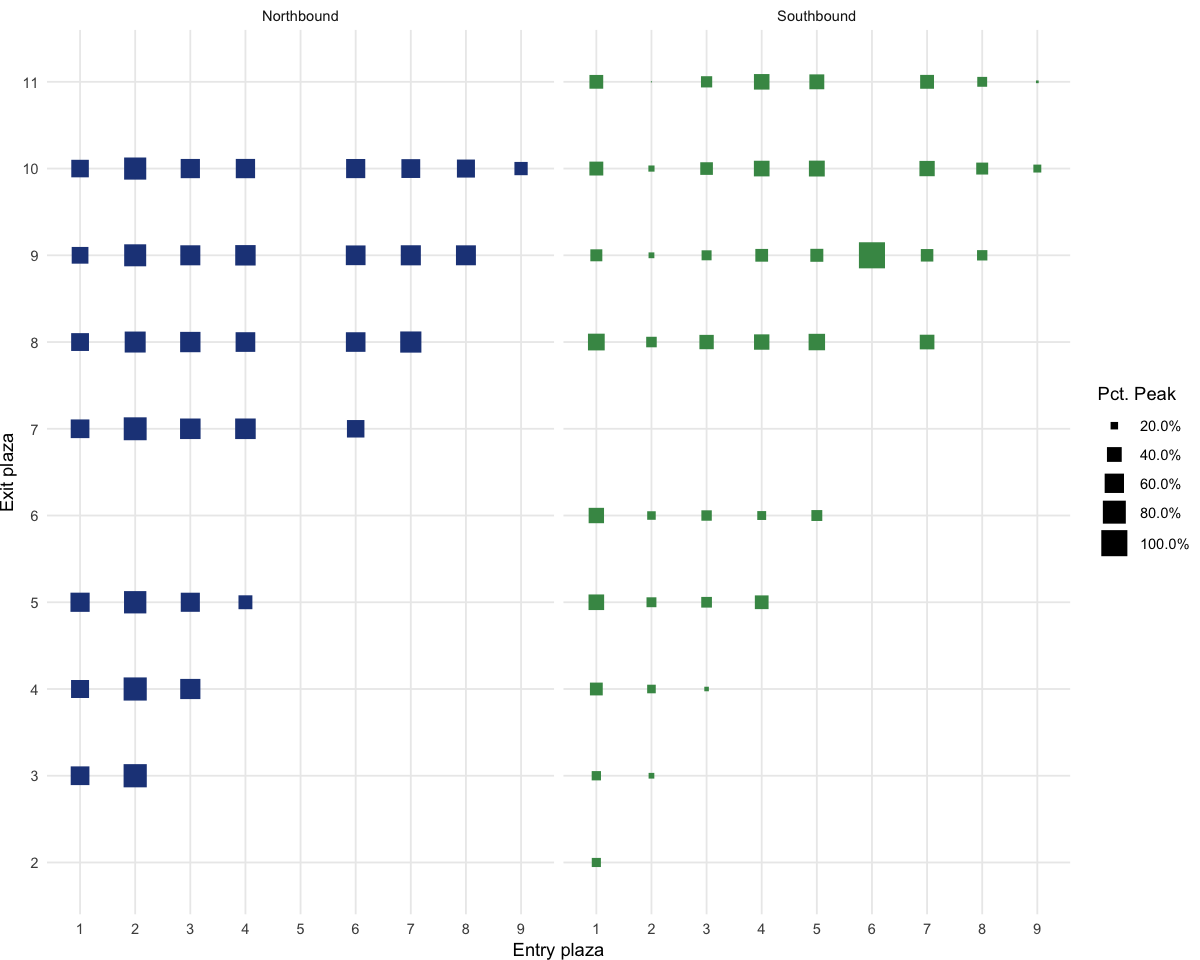

In [27]:
route_vols %>%
    ungroup() %>%
    mutate(direction = if_else(direction == "NB", "Northbound", "Southbound")) %>%
ggplot(aes(as_factor(entry), as_factor(exit), color=direction, size=pct)) +
    facet_wrap("direction") +
    geom_point(shape=15) + 
    scale_color_manual(values=c("#224488", "#449555")) +
    scale_size_continuous(labels=scales::percent, range=c(0, 7)) +
    guides(color=F) +
    labs(size="Pct. Peak", x="Entry plaza", y="Exit plaza", color="HOT lanes") +
    theme_minimal() +
    theme(plot.margin=grid::unit(c(0,0,0,0), "mm"))

ggsave("../../../img/trips_peak.png", width=6.5, height=3, dpi=320)

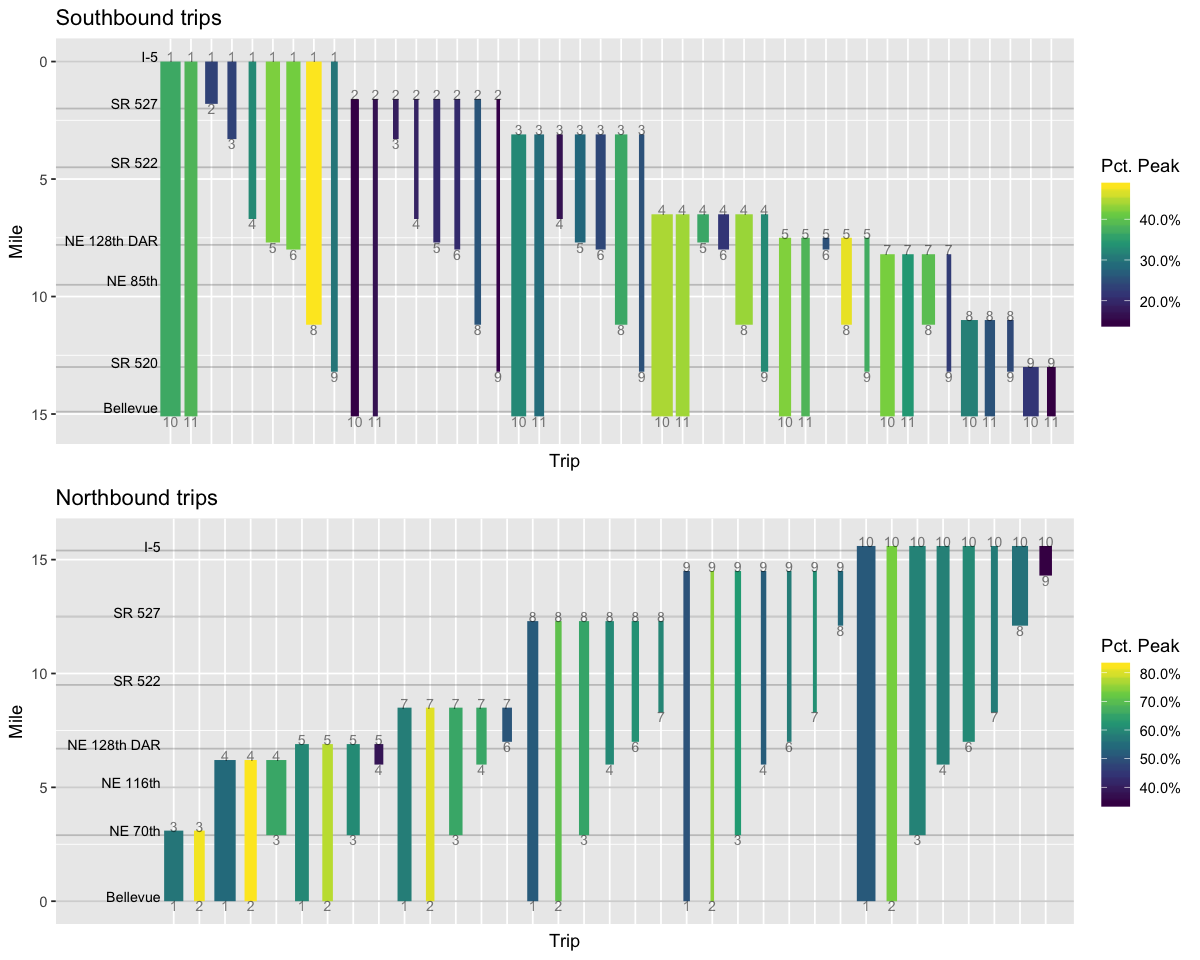

In [90]:
p_SB = filter(route_vols, direction=="SB", entry != exit) %>%
ggplot(aes(reorder(id, entry), ymin=entry_mp, ymax=exit_mp+0.2, size=volume, color=pct)) + 
    geom_hline(aes(yintercept=mp), lty="solid", alpha=0.2, data=ann_sb) +
    geom_linerange() + 
    geom_text(aes(x=0.4, y=mp, label=label), size=3, hjust="right", nudge_y=0.2, data=ann_sb, inherit.aes=F) +
    geom_text(aes(label=exit, y=exit_mp), size=3, color="black", alpha=0.5, nudge_y=-0.4) + 
    geom_text(aes(label=entry, y=entry_mp), size=3, color="black", alpha=0.5, nudge_y=+0.2) + 
    coord_cartesian(xlim=c(-4, 44.5)) + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + 
    guides(size=F, alpha=F) + 
    scale_y_reverse() +
    scale_color_viridis_c(label=scales::percent) +
    labs(title="Southbound trips", x="Trip", y="Mile", color="Pct. Peak")

p_NB = filter(route_vols, direction=="NB", entry != exit) %>%
ggplot(aes(reorder(id, exit), ymin=entry_mp, ymax=exit_mp+0.2, size=volume, color=pct)) + 
    geom_hline(aes(yintercept=mp), lty="solid", alpha=0.2, data=ann_nb) +
    geom_linerange() + 
    geom_text(aes(x=0.5, y=mp, label=label), size=3, hjust="right", nudge_y=0.2, data=ann_nb, inherit.aes=F) +
    geom_text(aes(label=exit, y=exit_mp), size=3, color="black", alpha=0.5, nudge_y=0.4) + 
    geom_text(aes(label=entry, y=entry_mp), size=3, color="black", alpha=0.5, nudge_y=-0.2) + 
    coord_cartesian(xlim=c(-3, 35.5)) + 
    theme(axis.text.x=element_blank(), axis.ticks.x=element_blank()) + 
    guides(size=F, alpha=F) + 
    scale_color_viridis_c(label=scales::percent) +
    labs(title="Northbound trips", x="Trip", y="Mile", color="Pct. Peak")

gridExtra::grid.arrange(p_SB, p_NB, ncol=1, padding=0)